In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import functions

import glob
import re




In [2]:

start_date = "1990-07-31"
end_date = "2021-06-30"


def filter_by_date(df, start_date = start_date, end_date = end_date, date_column='D'):
    """
    Filters a DataFrame to include only rows where the date_column is within the given range.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        start_date (str or pd.Timestamp): The start date (inclusive).
        end_date (str or pd.Timestamp): The end date (inclusive).
        date_column (str): The column containing date values (default is 'D').

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    df[date_column] = pd.to_datetime(df[date_column])  # Convert to datetime
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]

In [3]:
path = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/TL/'
dfspot1_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover1.csv', index_col = 0).fillna(0)
dfspot2_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover2.csv', index_col = 0).fillna(0)
dfspot3_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover3.csv', index_col = 0).fillna(0)
dfspot4_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover4.csv', index_col = 0).fillna(0)
dfspot5_df = pd.read_csv(path + 'langtang_monthly_dfspot_count_landcover5.csv', index_col = 0).fillna(0)



dfspot1_df = filter_by_date(dfspot1_df)
dfspot2_df = filter_by_date(dfspot2_df)
dfspot3_df = filter_by_date(dfspot3_df)
dfspot4_df = filter_by_date(dfspot4_df)
dfspot5_df = filter_by_date(dfspot5_df)


In [29]:
# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'  # December, January, February (Winter)
    elif month in [3, 4, 5]:
        return 'MAM'  # March, April, May (Spring)
    elif month in [6, 7, 8]:
        return 'JJA'  # June, July, August (Summer)
    else:
        return 'SON'  # September, October, November (Autumn)



# Define a function to categorize seasons
def get_monsoon(month):
    if month in [1, 2, 3, 4]:
        return 'before monsoon'  
    elif month in [5, 6, 7, 8, 9]:
        return month  # should remain the same 
    elif month in [10, 11, 12]:
        return 'after monsoon'  # June, July, August (Summer)









def prepare_dfcount_for_plot(dfcount):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 

def prepare_dfcount_for_heatmap(dfcount, temporal_col):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    melted['monsoon'] = melted['D_month'].apply(get_monsoon)
    
    melted = melted.groupby([temporal_col, 'elevation_bin'])['dfs_count'].mean().reset_index()
    toplot = melted.pivot(index="elevation_bin", columns=temporal_col, values="dfs_count")
    return toplot 


In [30]:
dfspot1 = prepare_dfcount_for_heatmap(dfspot1_df, 'D_month').dropna()
dfspot2 = prepare_dfcount_for_heatmap(dfspot2_df, 'D_month').dropna()
dfspot3 = prepare_dfcount_for_heatmap(dfspot3_df, 'D_month').dropna()
dfspot4 = prepare_dfcount_for_heatmap(dfspot4_df, 'D_month').dropna()
dfspot5 = prepare_dfcount_for_heatmap(dfspot5_df, 'D_month').dropna()

# Compute global vmin and vmax across all datasets
vmin = min(df.min().min() for df in [dfspot1, dfspot2, dfspot3, dfspot4, dfspot5])
vmax = max(df.max().max() for df in [dfspot1, dfspot2, dfspot3, dfspot4, dfspot5])


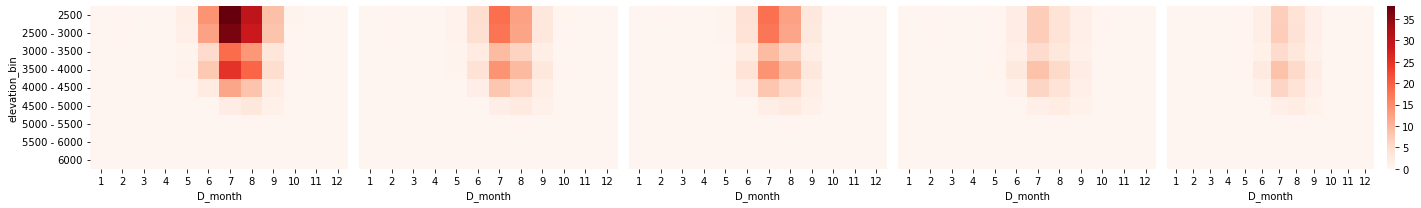

In [31]:
fig = plt.figure(figsize=(20, 3), layout = 'tight')

mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.heatmap(dfspot1, ax = mosaic['a'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot2, ax = mosaic['b'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot3, ax = mosaic['c'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot4, ax = mosaic['d'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = False)
sns.heatmap(dfspot5, ax = mosaic['e'], cmap ='Reds', vmin=vmin, vmax=vmax, cbar = True)

mosaic['b'].set_ylabel('')
mosaic['b'].set_yticks([])

mosaic['c'].set_ylabel('')
mosaic['c'].set_yticks([])

mosaic['d'].set_ylabel('')
mosaic['d'].set_yticks([])
mosaic['e'].set_ylabel('')
mosaic['e'].set_yticks([])

testplots = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/'
# plt.savefig(testplots + 'dfspot_count_all_landcovers_seasons.png', dpi = 300, bbox_inches = 'tight')

In [7]:
def prepare_dfcount_for_barplot(dfcount, landcover_idx):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    melted['monsoon'] = melted['D_month'].apply(get_monsoon)

    melted['landcover'] = f'landcover {landcover_idx}'
    return melted 




In [8]:
dfspot1 = prepare_dfcount_for_barplot(dfspot1_df, 1).fillna(0)
dfspot2 = prepare_dfcount_for_barplot(dfspot2_df, 2).fillna(0)
dfspot3 = prepare_dfcount_for_barplot(dfspot3_df, 3).fillna(0)
dfspot4 = prepare_dfcount_for_barplot(dfspot4_df, 4).fillna(0)
dfspot5 = prepare_dfcount_for_barplot(dfspot5_df, 5).fillna(0)


In [9]:
dfspot_all = pd.concat([dfspot1, dfspot2, dfspot3, dfspot4, dfspot5],ignore_index=True)



dfspot_jja = dfspot_all[dfspot_all['season'] == 'JJA']
dfspot_mam = dfspot_all[dfspot_all['season'] == 'MAM']
dfspot_djf = dfspot_all[dfspot_all['season'] == 'DJF']
dfspot_son = dfspot_all[dfspot_all['season'] == 'SON']


In [10]:
dfspot_all.season.unique()

array(['SON', 'JJA', 'MAM', 'DJF'], dtype=object)

In [11]:
# sns.barplot(data = dfspot_jja, x = 'landcover', y ='dfs_count')

/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_57671/2707848643.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(dfspot_all, x='landcover', y='dfs_count', ax=mosaic['a'], palette=color_mapping)#, ci = 'ci')
/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_57671/2707848643.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(dfspot_djf, x='landcover', y='dfs_count', ax=mosaic['b'], palette=color_mapping)#, ci = 'ci')
/var/folders/31/xdyntby945q7564txk4rqyh40000gp/T/ipykernel_57671/2707848643.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

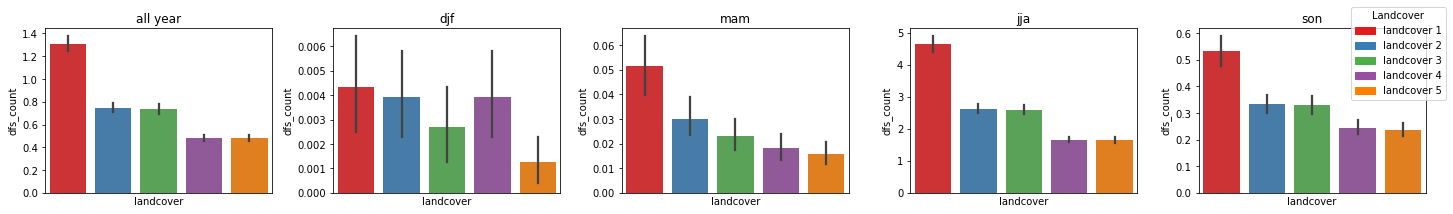

In [12]:
vmax = dfspot_all['dfs_count'].max()

fig = plt.figure(figsize=(20, 3), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')

# Define the color palette
palette = sns.color_palette('Set1')

# Get unique landcover types
landcover_categories = dfspot_all['landcover'].unique()

# Create a dictionary mapping landcover types to colors
color_mapping = dict(zip(landcover_categories, palette[:len(landcover_categories)]))

# Plot barplots with consistent colors
sns.barplot(dfspot_all, x='landcover', y='dfs_count', ax=mosaic['a'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_djf, x='landcover', y='dfs_count', ax=mosaic['b'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_mam, x='landcover', y='dfs_count', ax=mosaic['c'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_jja, x='landcover', y='dfs_count', ax=mosaic['d'], palette=color_mapping)#, ci = 'ci')
sns.barplot(dfspot_son, x='landcover', y='dfs_count', ax=mosaic['e'], palette=color_mapping)#, ci = 'ci')

# Create a custom legend
handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[lc]) for lc in landcover_categories]
fig.legend(handles, landcover_categories, title="Landcover", loc='upper right', bbox_to_anchor=(1.01, 1))

mosaic['a'].set_title('all year')
mosaic['b'].set_title('djf')
mosaic['c'].set_title('mam')
mosaic['d'].set_title('jja')
mosaic['e'].set_title('son')

mosaic['a'].set_xticks([])
mosaic['b'].set_xticks([])
mosaic['c'].set_xticks([])
mosaic['d'].set_xticks([])
mosaic['e'].set_xticks([])



# mosaic['b'].set_ylim([0, 8])
# mosaic['c'].set_ylim([0, 8])
# mosaic['d'].set_ylim([0, 8])
# mosaic['e'].set_ylim([0, 8])

testplots = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/'
# plt.savefig(testplots + 'dfspot_count_all_landcovers_barplots.png', dpi = 300, bbox_inches = 'tight')


# df vs floods

In [13]:

# Filter the DataFrame for the specified date range
def prepare_dfcount_for_plot(dfcount):
    dfcount['D'] = pd.to_datetime(dfcount['D'])
    # dfcount = dfcount[(dfcount['D'] >= start_date) & (dfcount['D'] <= end_date)]

    dfcount = dfcount.rename(columns={'D_year': 'year', 'D_month': 'month'})
    dfcount = dfcount.drop('D', axis = 1)
    dfcount['date_id'] = dfcount['year'].astype(str)+ "_" + dfcount['month'].astype(str)
    melted = pd.melt(dfcount, id_vars=['date_id', 'year', 'month'], var_name='elevation', value_name='dfs_count')
    
    # melted = pd.melt(dfcount, id_vars=['date_id'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    # create unique id for elevation and month for merging
    melted['elevation'] = melted['elevation'].astype(int)
    melted['id'] = melted.index.astype(str)+ "_" + melted['elevation'].astype(str) + "_" + melted['year'].astype(str)+ "_" + melted['month'].astype(str)
    
    melted['season'] = melted['month'].apply(get_season)
    melted['monsoon'] = melted['month'].apply(get_monsoon)
    # melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 

def merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column):
    """
    Merges a list of dataframes on specified columns and adds a column from a 'dfspot' dataframe.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to merge sequentially.
        dfspot (pd.DataFrame): A dataframe containing a column to add after the merges.
        merge_on (list of str): Columns to use as the merge keys.
        dfspot_column (str): The name of the column in `dfspot` to add after merging.
        
    Returns:
        pd.DataFrame: The merged dataframe with the additional column from `dfspot`.
    """
    
    # Start with the first dataframe in `dfs` and automatically get the count column
    count_column = [col for col in dfs[0].columns if col.startswith('dfs_count')][0]
    merged_df = dfs[0][merge_on + [count_column]]
    
    # Iterate over remaining dataframes and merge each sequentially
    for df in dfs[1:]:
        count_column = [col for col in df.columns if col.startswith('dfs_count')][0]
        merged_df = pd.merge(merged_df, df[merge_on + [count_column]], on=merge_on)
    
    # Add the `dfspot_column` from `dfspot` dataframe to the merged dataframe
    merged_df['dfspot_count'] = dfspot[dfspot_column]
    
    return merged_df


def calculate_floods(df):
    # df percent 
    df[f'dfs_count_60_percent'] = (df[f'dfs_count_60percent'] *100) / df.dfspot_count
    df[f'dfs_count_50_percent'] = (df[f'dfs_count_50percent'] *100) / df.dfspot_count
    df[f'dfs_count_40_percent'] = (df[f'dfs_count_40percent'] *100) / df.dfspot_count
    df[f'dfs_count_30_percent'] = (df[f'dfs_count_30percent'] *100) / df.dfspot_count
    df[f'dfs_count_20_percent'] = (df[f'dfs_count_20percent'] *100) / df.dfspot_count
    # ff count 
    df[f'ffs_count_60'] = df.dfspot_count - df[f'dfs_count_60percent']
    df[f'ffs_count_50'] = df.dfspot_count - df[f'dfs_count_50percent']
    df[f'ffs_count_40'] = df.dfspot_count - df[f'dfs_count_40percent']
    df[f'ffs_count_30'] = df.dfspot_count - df[f'dfs_count_30percent']
    df[f'ffs_count_20'] = df.dfspot_count - df[f'dfs_count_20percent']
    # ff percent
    df[f'ffs_count_60_percent'] = (df[f'ffs_count_60'] *100) / df.dfspot_count
    df[f'ffs_count_50_percent'] = (df[f'ffs_count_50'] *100) / df.dfspot_count
    df[f'ffs_count_40_percent'] = (df[f'ffs_count_40'] *100) / df.dfspot_count
    df[f'ffs_count_30_percent'] = (df[f'ffs_count_30'] *100) / df.dfspot_count
    df[f'ffs_count_20_percent'] = (df[f'ffs_count_20'] *100) / df.dfspot_count
    return df




In [14]:
# read one file and compare it to the DFSPOT


# /Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_20percent/langtang_monthly_dfs_count_20percent_landcover1.csv

In [15]:
import glob
import pandas as pd
import re

landcover_idx = 5

# Base directory where all output_Xpercent folders are located
base_directory = "/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/"

# Use glob to find all relevant files in output_XXpercent folders
file_pattern = f"{base_directory}/output_*/langtang_monthly_dfs_count_*_landcover{landcover_idx}.csv"
files = glob.glob(file_pattern)

dfs = []

# Loop through the files and process them
for file in files:
    # Extract the percentile from the folder name
    percentile = re.search(r'output_(\d+percent)', file).group(1)
    
    # Extract the landcover number from the file name
    landcover_number = re.search(r'landcover(\d+)', file).group(1)
    print(landcover_number)
    print(file)
    # Read the file into a DataFrame
    df = pd.read_csv(file, index_col=0).fillna(0)
    df = filter_by_date(df)

    # Apply your processing function
    processed_df = prepare_dfcount_for_plot(df)
    
    # Rename the 'dfs_count' column to include percentile and landcover number
    processed_df = processed_df.rename(columns={'dfs_count': f'dfs_count_{percentile}'})
    # Append to the list
    dfs.append(processed_df)

merge_on = ['year', 'month', 'elevation', 'elevation_bin', 'id']
dfspot_column = 'dfs_count'

if landcover_idx == 1:
    dfspot = dfspot1
if landcover_idx == 2:
    dfspot = dfspot2
if landcover_idx == 3:
    dfspot = dfspot3
if landcover_idx == 4:
    dfspot = dfspot4
if landcover_idx == 5:
    dfspot = dfspot5


dfmerged = merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column)
dffloods = calculate_floods(dfmerged)


outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/'
# dffloods.to_csv(outpath + f'langtang_df_vs_floods_once_landcover{landcover_idx}.csv')


5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_30percent/langtang_monthly_dfs_count_30percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_20percent/langtang_monthly_dfs_count_20percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_60percent/langtang_monthly_dfs_count_60percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_40percent/langtang_monthly_dfs_count_40percent_landcover5.csv
5
/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/SL_once/output_50percent/langtang_monthly_dfs_count_50percent_landcover5.csv


# plots for df vs floods - stacked barplots 

calculate mean per month? then make 

In [36]:
# read those files 
# outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025Jan_output/df_vs_floods/'

landcover1 = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover1.csv', index_col=0)
landcover2 = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover2.csv', index_col=0)
landcover3 = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover3.csv', index_col=0)
landcover4 = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover4.csv', index_col=0)
landcover5 = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover5.csv', index_col=0)


def remove_elevation_bins(df, bins_to_remove=["5500-6000", "6000"]):
    return df[~df['elevation_bin'].isin(bins_to_remove)]

# Example usage:
landcover1 = remove_elevation_bins(landcover1)
landcover2 = remove_elevation_bins(landcover2)
landcover3 = remove_elevation_bins(landcover3)
landcover4 = remove_elevation_bins(landcover4)
landcover5 = remove_elevation_bins(landcover5)






landcover1['monsoon'] = landcover1.month.apply(get_monsoon)
landcover2['monsoon'] = landcover2.month.apply(get_monsoon)
landcover3['monsoon'] = landcover3.month.apply(get_monsoon)
landcover4['monsoon'] = landcover4.month.apply(get_monsoon)
landcover5['monsoon'] = landcover5.month.apply(get_monsoon)

def monthly_mean_per_elevation(df):
    mean = df.groupby(['elevation_bin', 'month']).mean().reset_index() 
    return mean

def monsoon_mean_per_elevation(df):
    mean = df.groupby(['elevation_bin', 'monsoon']).mean().reset_index() 
    return mean

landcover1monthly = monthly_mean_per_elevation(landcover1)
landcover2monthly = monthly_mean_per_elevation(landcover2)
landcover3monthly = monthly_mean_per_elevation(landcover3)
landcover4monthly = monthly_mean_per_elevation(landcover4)
landcover5monthly = monthly_mean_per_elevation(landcover5)



landcover1monsoon = monsoon_mean_per_elevation(landcover1)
landcover2monsoon = monsoon_mean_per_elevation(landcover2)
landcover3monsoon = monsoon_mean_per_elevation(landcover3)
landcover4monsoon = monsoon_mean_per_elevation(landcover4)
landcover5monsoon = monsoon_mean_per_elevation(landcover5)


<AxesSubplot:label='E', xlabel='month', ylabel='dfs_count_60_percent'>

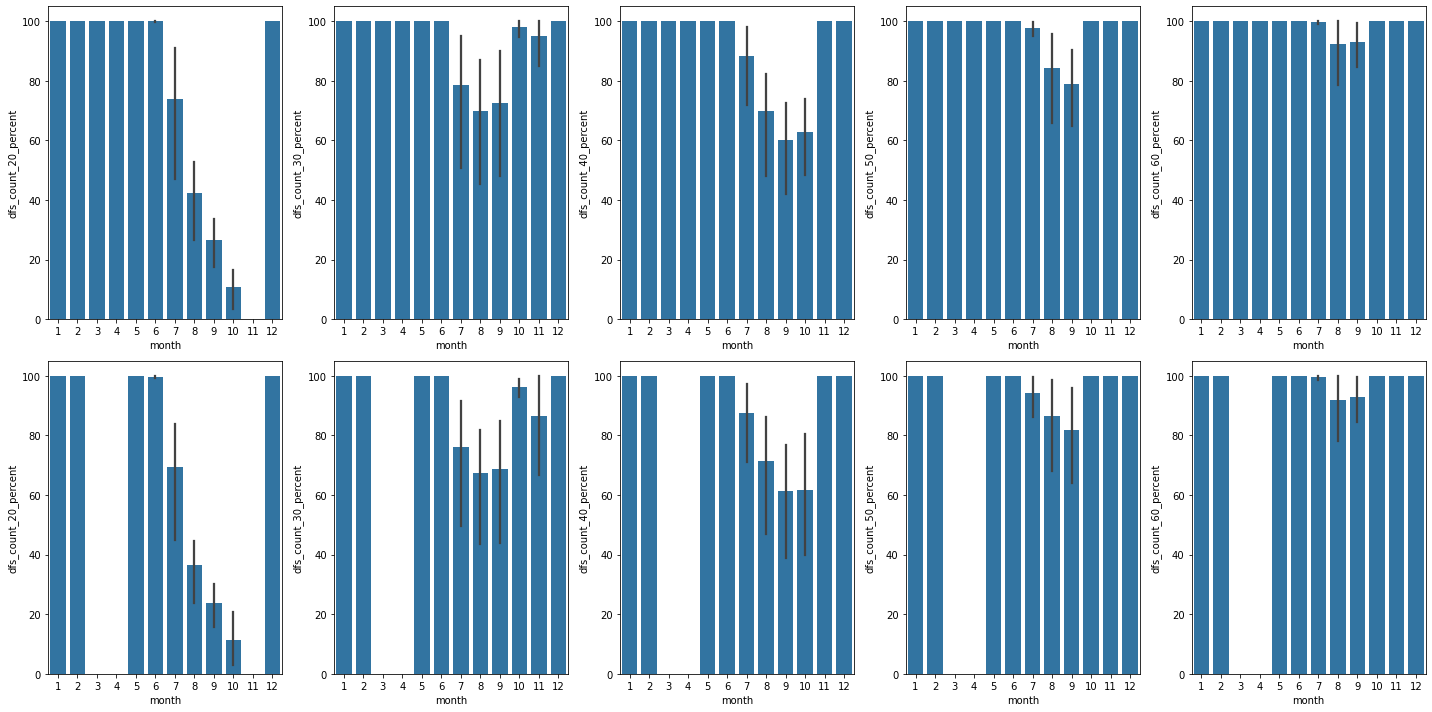

In [38]:

fig = plt.figure(figsize=(20, 10), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')


sns.barplot(data = landcover1monthly, y = 'dfs_count_20_percent', x='month', ax = mosaic['a'])
sns.barplot(data = landcover1monthly, y = 'dfs_count_30_percent', x='month', ax = mosaic['b'])#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover1monthly, y = 'dfs_count_40_percent', x='month', ax = mosaic['c'])#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover1monthly, y = 'dfs_count_50_percent', x='month', ax = mosaic['d'])
sns.barplot(data = landcover1monthly, y = 'dfs_count_60_percent', x='month', ax = mosaic['e'])



sns.barplot(data = landcover2monthly, y = 'dfs_count_20_percent', x='month', ax = mosaic['A'])#, hue = 'elevation_bin')
sns.barplot(data = landcover2monthly, y = 'dfs_count_30_percent', x='month', ax = mosaic['B'])#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover2monthly, y = 'dfs_count_40_percent', x='month', ax = mosaic['C'])#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover2monthly, y = 'dfs_count_50_percent', x='month', ax = mosaic['D'])
sns.barplot(data = landcover2monthly, y = 'dfs_count_60_percent', x='month', ax = mosaic['E'])



In [39]:
# plots - 
# remove everything above 5500
# calculate the mean dfspot for all evelations 
# assign month the class: either the month itself (within monsoon) or "before monsoon"/"after monsoon"
# color bars per dfspot 

In [40]:
def monthly_mean(df):
    mean = df.groupby(['month']).mean().reset_index() 
    return mean


landcover1monthly_comb = monthly_mean(landcover1)


<AxesSubplot:label='e', xlabel='month', ylabel='dfs_count_60_percent'>

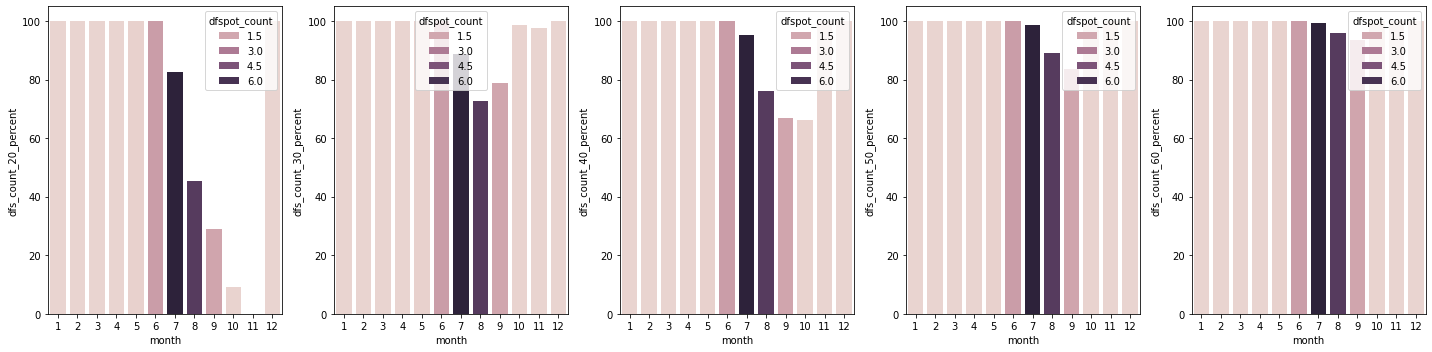

In [41]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.barplot(data = landcover1monthly_comb, y = 'dfs_count_20_percent', x='month', ax = mosaic['a'], hue = 'dfspot_count')
sns.barplot(data = landcover1monthly_comb, y = 'dfs_count_30_percent', x='month', ax = mosaic['b'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover1monthly_comb, y = 'dfs_count_40_percent', x='month', ax = mosaic['c'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = landcover1monthly_comb, y = 'dfs_count_50_percent', x='month', ax = mosaic['d'], hue = 'dfspot_count')
sns.barplot(data = landcover1monthly_comb, y = 'dfs_count_60_percent', x='month', ax = mosaic['e'], hue = 'dfspot_count')


In [42]:
def monsoon_mean(df):
    mean = df.groupby(['monsoon']).mean().reset_index() 
    return mean


landcover1monsoon_comb = monsoon_mean(landcover1)
landcover2monsoon_comb = monsoon_mean(landcover2)
landcover3monsoon_comb = monsoon_mean(landcover3)
landcover4monsoon_comb = monsoon_mean(landcover4)
landcover5monsoon_comb = monsoon_mean(landcover5)


order = ['before monsoon', '5', '6', '7', '8', '9', 'after monsoon']


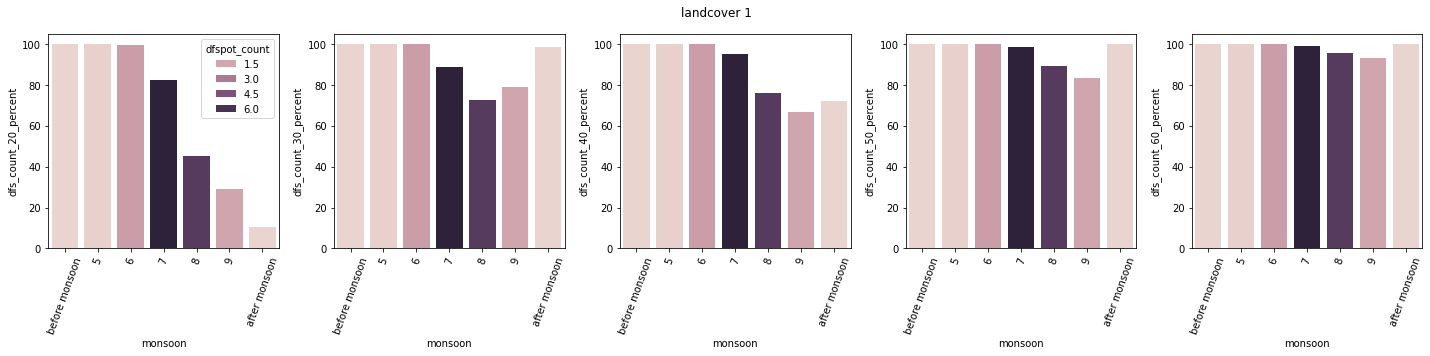

In [52]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.barplot(data = landcover1monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['a'], hue = 'dfspot_count', order = order)
sns.barplot(data = landcover1monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['b'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover1monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['c'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover1monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['d'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover1monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['e'], hue = 'dfspot_count',  order = order, legend = False)


# sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['A'], hue = 'dfspot_count', order = order)
# sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['B'], hue = 'dfspot_count',  order = order)
# sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['C'], hue = 'dfspot_count',  order = order)
# sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['D'], hue = 'dfspot_count',  order = order)
# sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['E'], hue = 'dfspot_count',  order = order)
# Turn on x-axis ticks for each axis in the mosaic

plt.suptitle('landcover 1')

for ax in mosaic.values():
    ax.set_xticks(ax.get_xticks())  
    ax.tick_params(axis='x', rotation=70)  


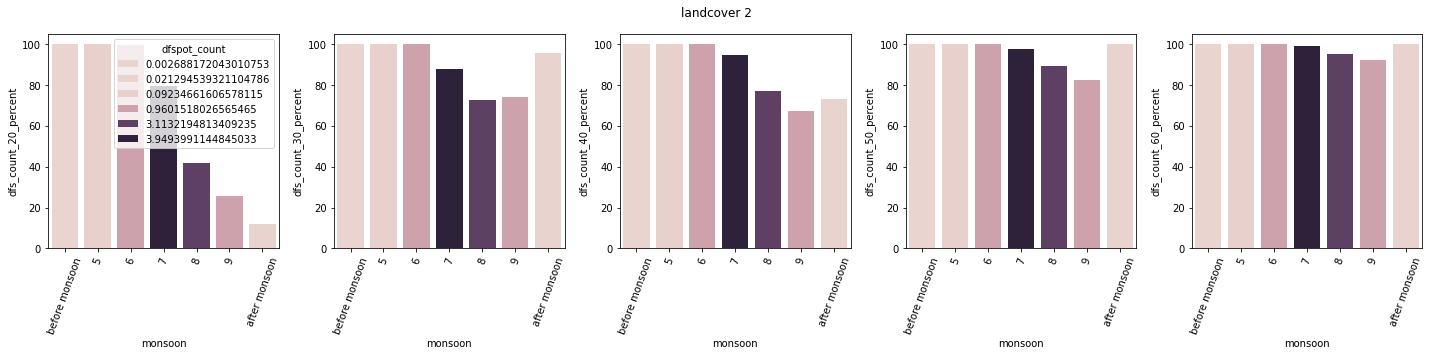

In [60]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['a'], hue = 'dfspot_count', order = order)
sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['b'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['c'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['d'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover2monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['e'], hue = 'dfspot_count',  order = order, legend = False)

plt.suptitle('landcover 2')

for ax in mosaic.values():
    ax.set_xticks(ax.get_xticks())  
    ax.tick_params(axis='x', rotation=70)  


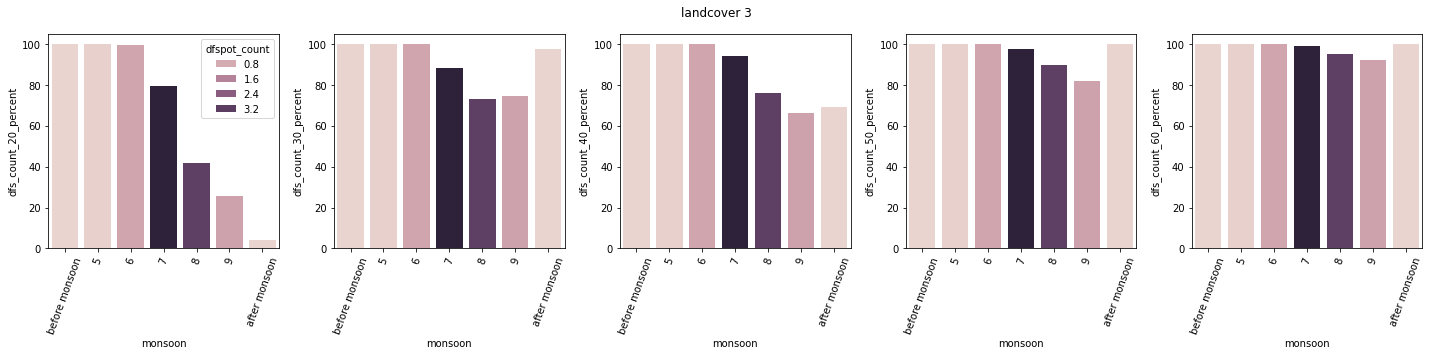

In [56]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.barplot(data = landcover3monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['a'], hue = 'dfspot_count', order = order)
sns.barplot(data = landcover3monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['b'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover3monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['c'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover3monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['d'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover3monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['e'], hue = 'dfspot_count',  order = order, legend = False)

plt.suptitle('landcover 3')

for ax in mosaic.values():
    ax.set_xticks(ax.get_xticks())  
    ax.tick_params(axis='x', rotation=70)  


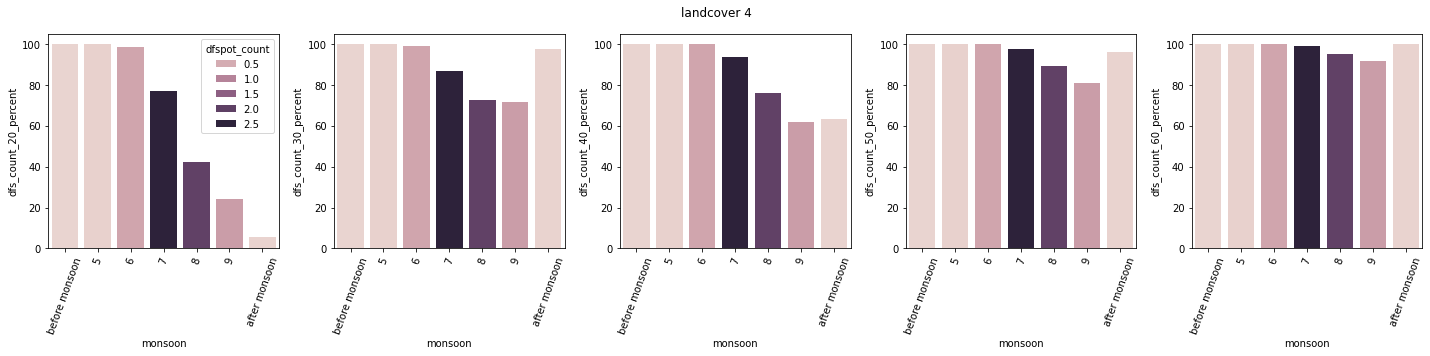

In [57]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')


sns.barplot(data = landcover4monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['a'], hue = 'dfspot_count', order = order)
sns.barplot(data = landcover4monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['b'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover4monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['c'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover4monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['d'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover4monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['e'], hue = 'dfspot_count',  order = order, legend = False)

plt.suptitle('landcover 4')

for ax in mosaic.values():
    ax.set_xticks(ax.get_xticks())  
    ax.tick_params(axis='x', rotation=70)  


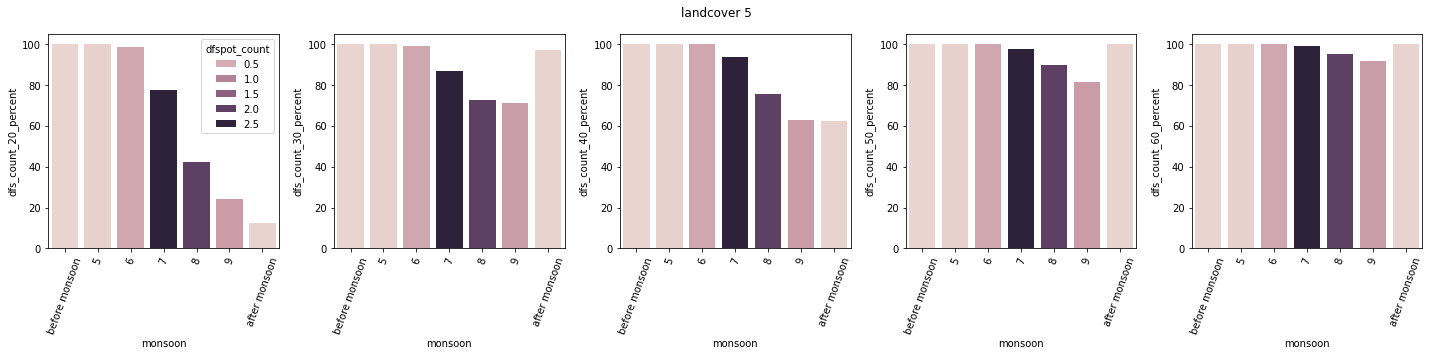

In [58]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ''')

sns.barplot(data = landcover5monsoon_comb, y = 'dfs_count_20_percent', x='monsoon', ax = mosaic['a'], hue = 'dfspot_count', order = order)
sns.barplot(data = landcover5monsoon_comb, y = 'dfs_count_30_percent', x='monsoon', ax = mosaic['b'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover5monsoon_comb, y = 'dfs_count_40_percent', x='monsoon', ax = mosaic['c'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover5monsoon_comb, y = 'dfs_count_50_percent', x='monsoon', ax = mosaic['d'], hue = 'dfspot_count',  order = order, legend = False)
sns.barplot(data = landcover5monsoon_comb, y = 'dfs_count_60_percent', x='monsoon', ax = mosaic['e'], hue = 'dfspot_count',  order = order, legend = False)

plt.suptitle('landcover 5')

for ax in mosaic.values():
    ax.set_xticks(ax.get_xticks())  
    ax.tick_params(axis='x', rotation=70)  
